In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
from scipy.optimize import curve_fit
import warnings
from TESStools import *
import celerite
from celerite import terms
from scipy.optimize import minimize

In [2]:
ysg_tics = [404850274,389437365,389565293,40404470,29984014]

In [3]:
def noise_func(f, alpha_0, tau, gamma, alpha_w):
    return alpha_0 / (1.0 + np.power((2.0*np.pi*tau*f),gamma)) + alpha_w

In [4]:
def log_noise(f, alpha_0, tau, gamma, alpha_w):
    return np.log10(noise_func(f, alpha_0, tau, gamma, alpha_w))

323.89171072083246 0.01778794028727421


/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


322.76203971547 0.017787932748165886


/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


324.59880106819276 0.03586727083626439


/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


323.7577400015701 0.017787909455610686


/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:110: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(lc['Time'].values,lc['Flux'].values,deg=deg)


323.83746567083887 0.017787891882718898


/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


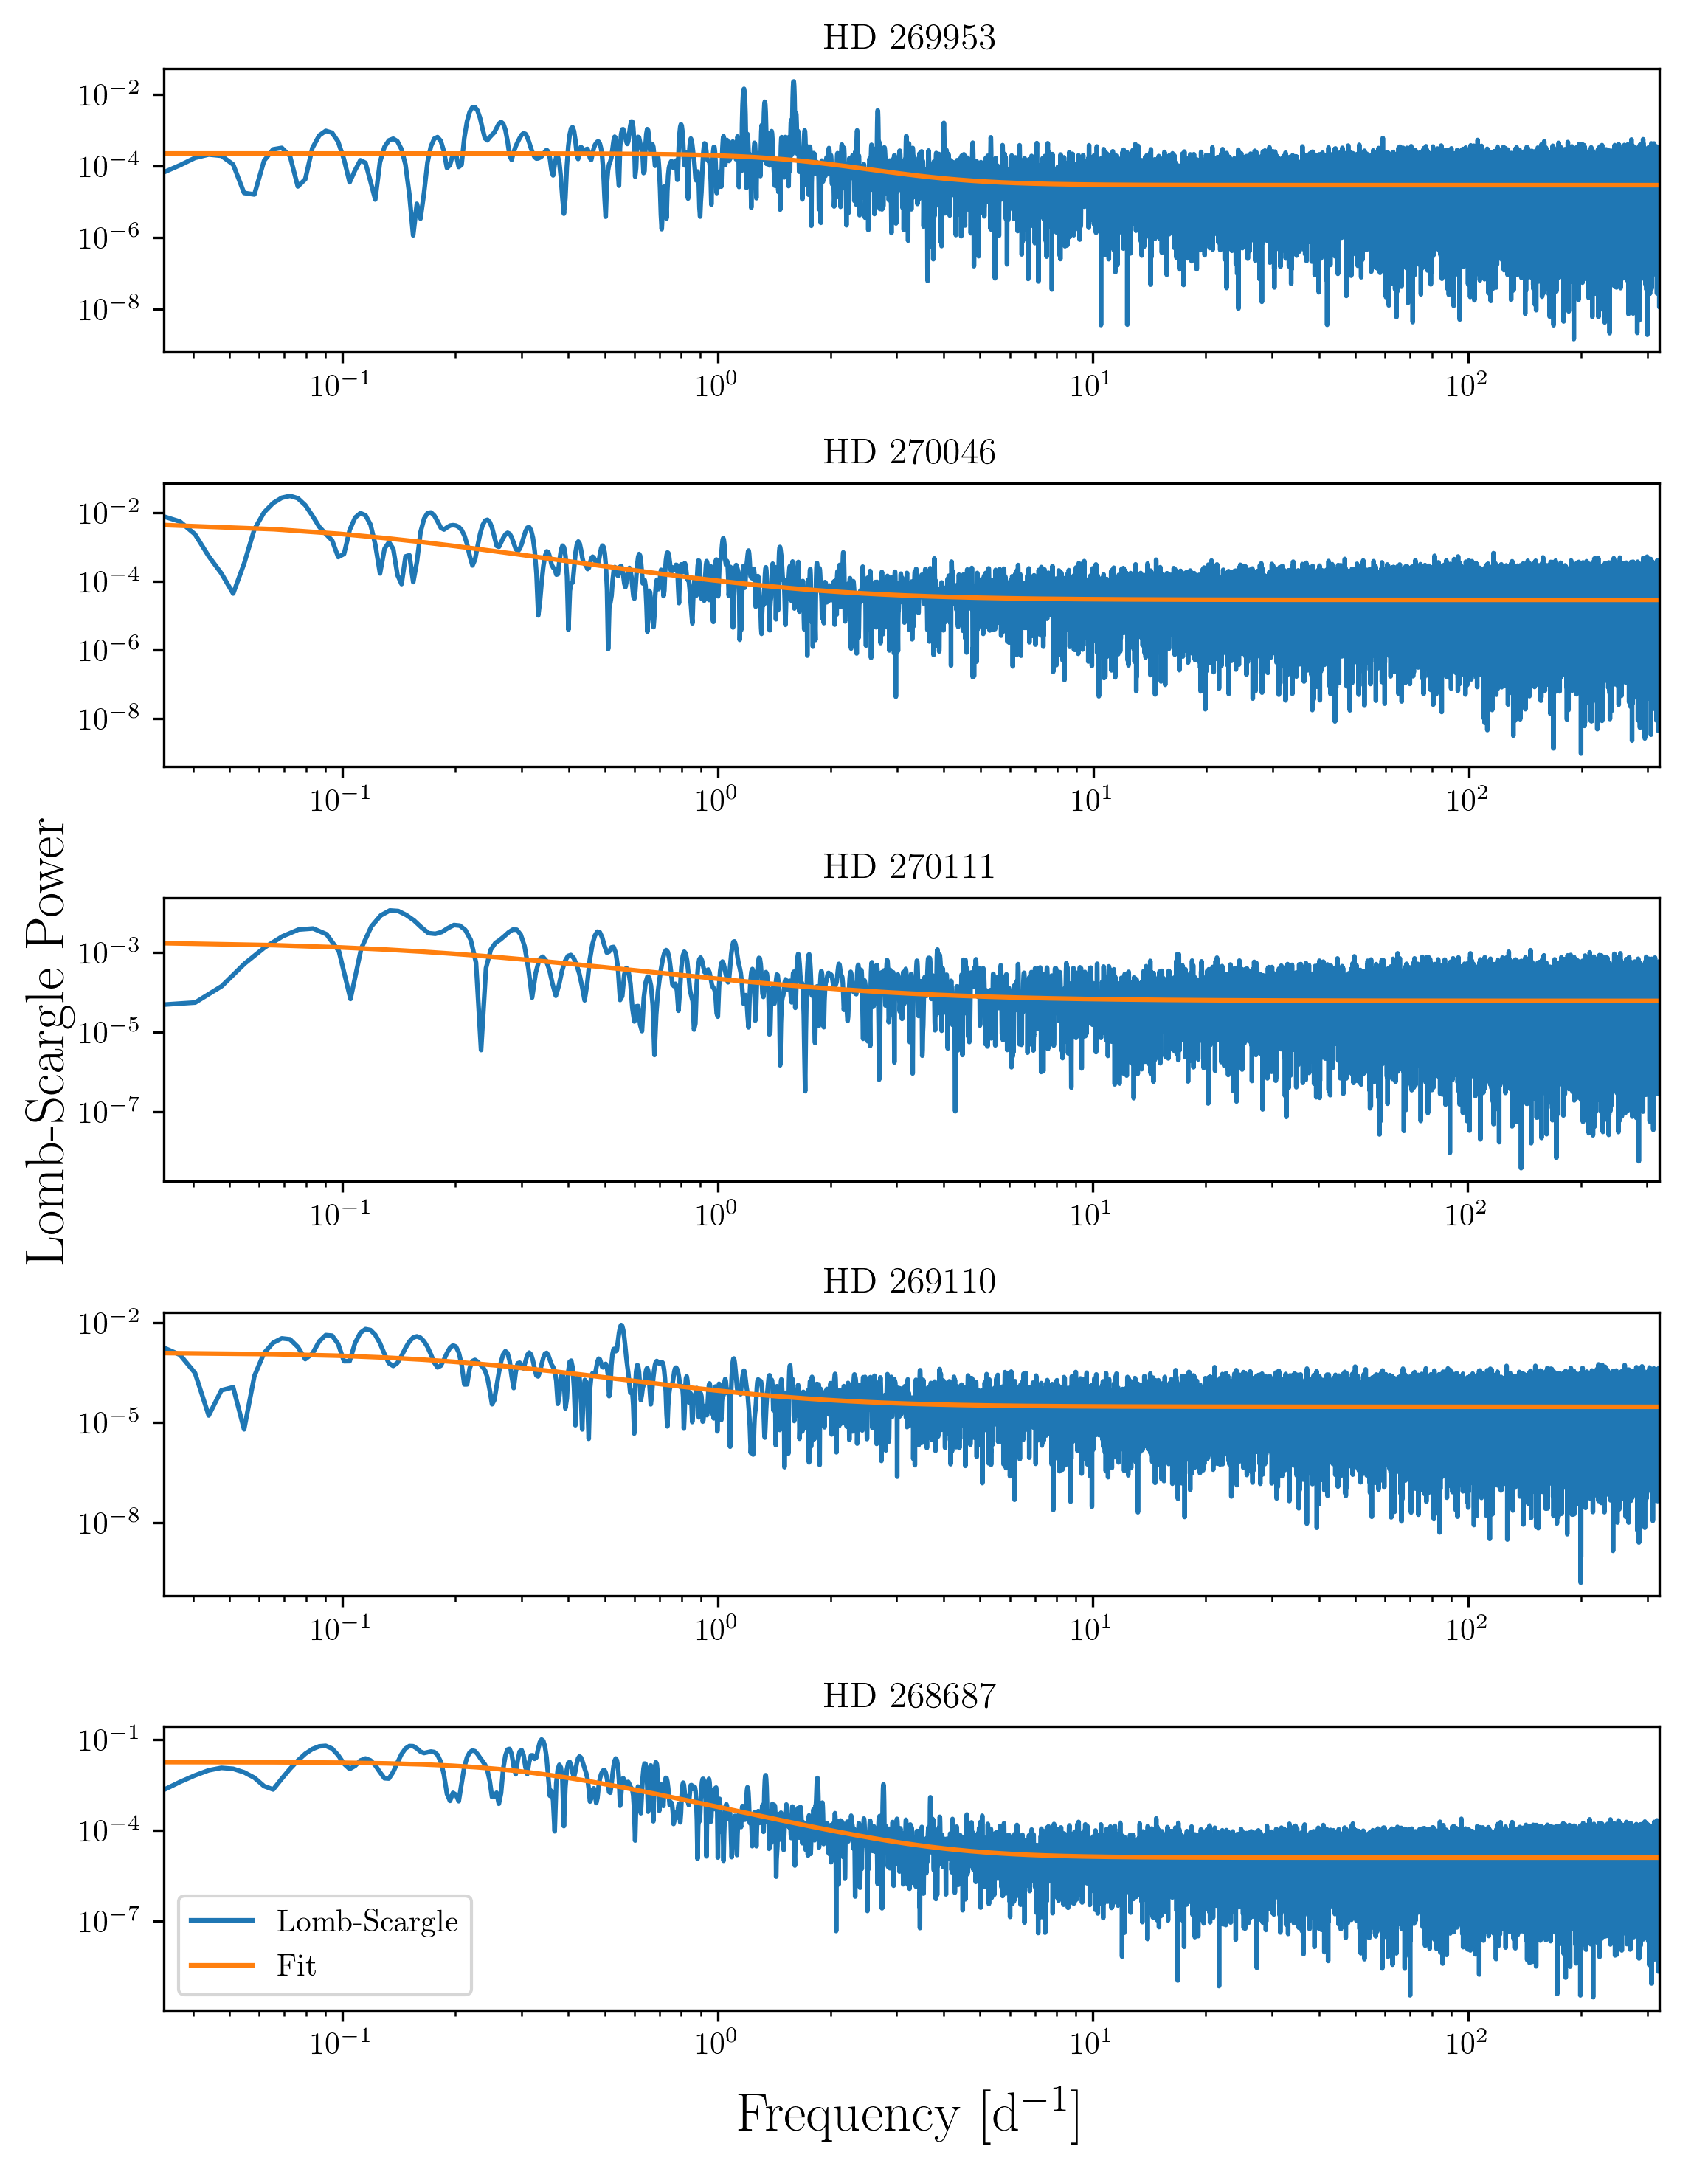

In [14]:
fig, axes = plt.subplots(5, figsize=(8,10),dpi=300)
popts = []
pcovs = []
for i,tid in enumerate(ysg_tics):
    fname = np.unique(massive['CommonName'][massive['ticid']==tid])[0].replace('*','').replace('V','')
    lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
    ax = axes[i]
    if (fname == 'HD 268687'):
        lc, p = polynorm(lc, deg=7)
        time, flux = lc['Time'], lc['NormFlux']
    else:
        time, flux = lc['Time'], lc['Flux']
        
    pseudo_NF = 0.5 / (np.mean(np.diff(time)))
    rayleigh = 1.0 / (np.max(time)-np.min(time))
    print(pseudo_NF,rayleigh)
    
    ls = LombScargle(time, flux)
    f, p = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF)
    
    if fname == 'HD 268687':
        p0 = popts[-1]
        bounds = ([-np.inf,-np.inf,-np.inf,1e-6],[np.inf,np.inf,np.inf,np.inf])
    else:
        p0 = [np.max(p), 1.0, 1.0, p[np.argmax(f)]]
        bounds = (-np.inf,np.inf)
        
    popt, pcov = curve_fit(log_noise, f, np.log10(p), bounds=bounds, p0=p0)
    popts.append(popt)
    pcovs.append(pcov)
    ax.loglog(f, p, label='Lomb-Scargle')
    ffit = np.linspace(1.0/30.0,pseudo_NF,10000)
    ax.loglog(ffit,noise_func(ffit,*popt),label='Fit')
    ax.set(title=fname, xlim=(1.0/30.0,pseudo_NF))
    if fname == 'HD 268687':
        ax.legend()

    
labax = fig.add_subplot(111)
labax.spines['top'].set_color('none')
labax.spines['bottom'].set_color('none')
labax.spines['left'].set_color('none')
labax.spines['right'].set_color('none')
labax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
labax.set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power')
labax.set_zorder(-1)
fig.tight_layout()

labax.xaxis.label.set_size(18)
labax.yaxis.label.set_size(18)
for tick in labax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in labax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
plt.savefig('../plots/ysg_noise_fits.pdf')
popts = np.array(popts)
pcovs = np.array(pcovs)
perrs = np.array([np.sqrt(np.diag(pcov)) for pcov in pcovs])

/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:110: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(lc['Time'].values,lc['Flux'].values,deg=deg)


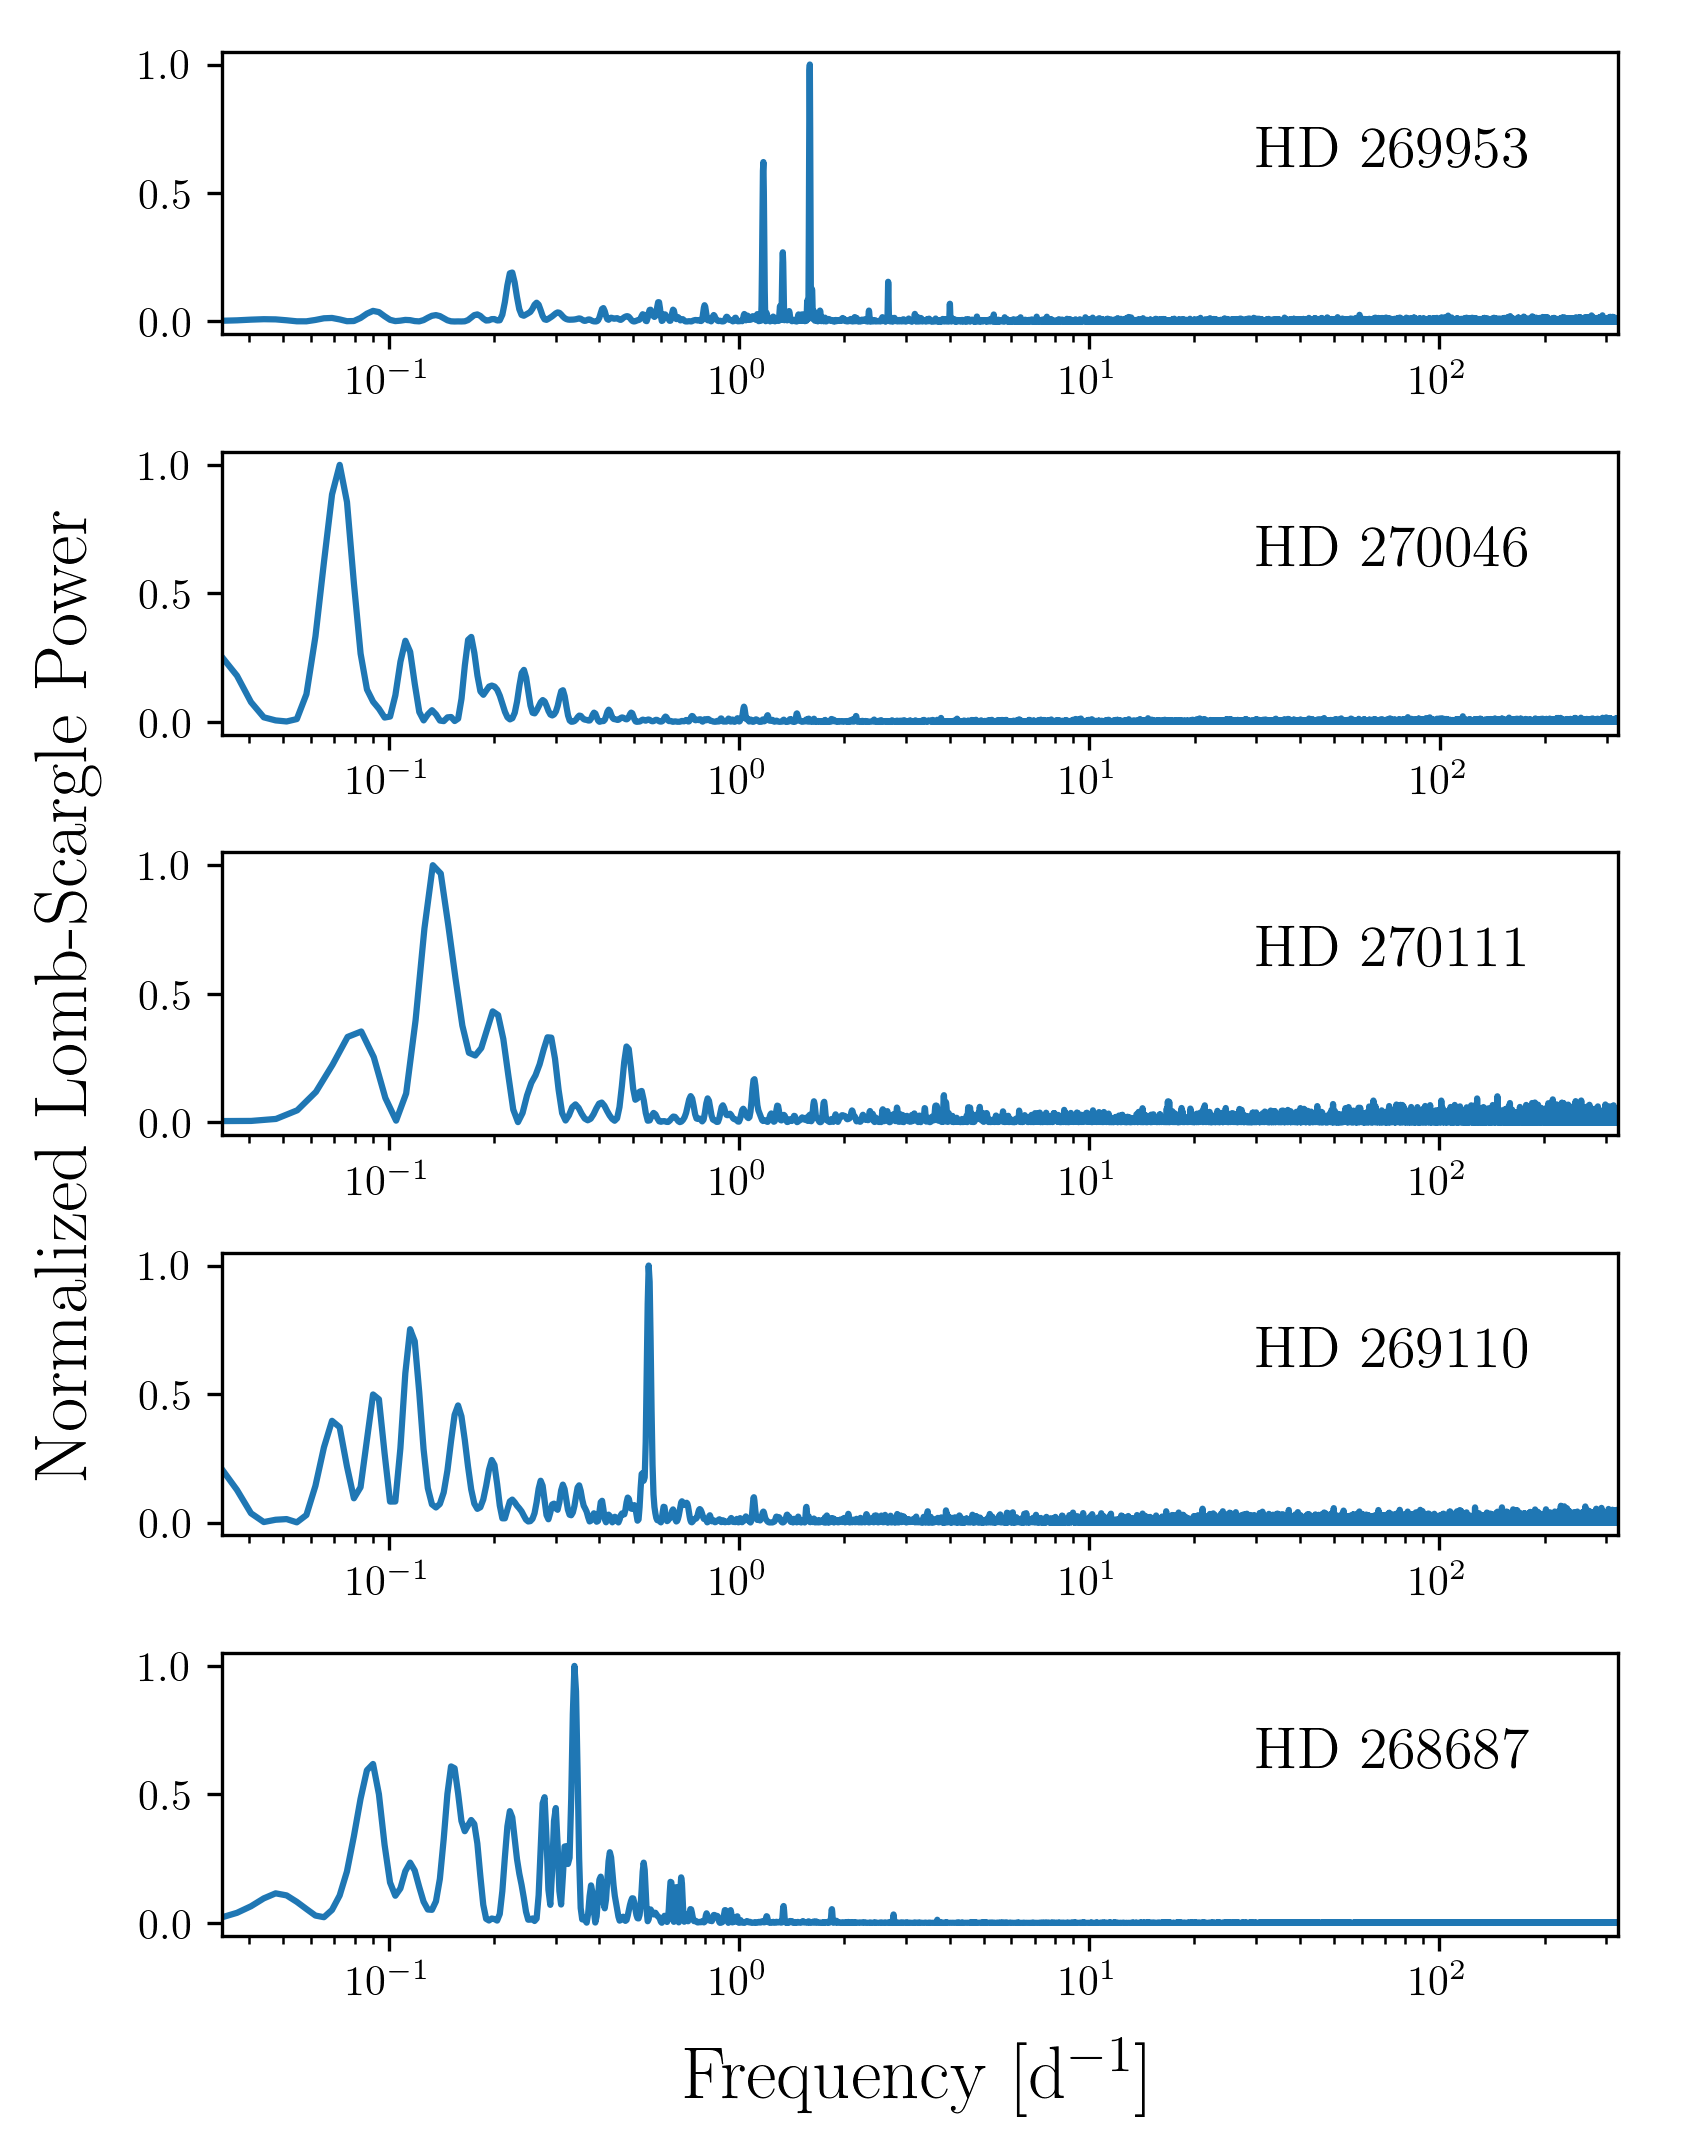

In [29]:
#We're gonna need to make a Figure real quick for the TESS Cycle 2 proposal
fig, axes = plt.subplots(5, figsize=(6,7.5),dpi=300)
for i,tid in enumerate(ysg_tics):
    fname = np.unique(massive['CommonName'][massive['ticid']==tid])[0].replace('*','').replace('V','')
    lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
    ax = axes[i]
    if (fname == 'HD 268687'):
        lc, p = polynorm(lc, deg=7)
        time, flux = lc['Time'], lc['NormFlux']
    else:
        time, flux = lc['Time'], lc['Flux']
        
    pseudo_NF = 0.5 / (np.mean(np.diff(time)))
    
    ls = LombScargle(time, flux, normalization='psd')
    f, p = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF)
    
    ax.plot(f, p/np.max(p), label='Lomb-Scargle')
    ax.text(30, 0.6, fname, fontsize=14)
    ax.set(xlim=(1.0/30.0,pseudo_NF), xscale='log')

    
labax = fig.add_subplot(111)
labax.spines['top'].set_color('none')
labax.spines['bottom'].set_color('none')
labax.spines['left'].set_color('none')
labax.spines['right'].set_color('none')
labax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
labax.set(xlabel='Frequency [d$^{-1}$]', ylabel='Normalized Lomb-Scargle Power')
labax.set_zorder(-1)
fig.tight_layout()

labax.xaxis.label.set_size(18)
labax.yaxis.label.set_size(18)
for tick in labax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in labax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.tight_layout()
plt.savefig('../../Proposals/TESS_C2/fig1b.pdf')

In [15]:
logLs = [5.437,np.nan,np.nan,5.251,5.169]
logTs = [3.692,np.nan,np.nan,3.750,3.784]
alpha_0s = popts[:,0]
e_alpha_0s = perrs[:,0]
taus = popts[:,1]
e_taus = perrs[:,1]
gammas = popts[:,2]
e_gammas = perrs[:,2]
alpha_ws = popts[:,3]
e_alpha_ws = perrs[:,3]

In [16]:
for a,ae,t,te,g,ge,w,we in zip(alpha_0s,e_alpha_0s,taus,e_taus,gammas,e_gammas,alpha_ws,e_alpha_ws):
    print('${0:.2f}\pm{1:.2f}$ & ${2:.2f}\pm{3:.2f}$ & ${4:.2f}\pm{5:.2f}$ & ${6:.2f}\pm{7:.3f}$ \\\\'.format(a/1e-4,ae/1e-4,t/1e-2,te/1e-2,g,ge,w/1e-5,we/1e-5).replace('e','\\times10^{'))

$1.94\pm0.18$ & $8.79\pm0.75$ & $3.06\pm0.28$ & $2.89\pm0.013$ \\
$49.54\pm23.13$ & $172.13\pm63.31$ & $1.76\pm0.09$ & $2.86\pm0.013$ \\
$17.73\pm7.93$ & $84.90\pm42.58$ & $1.40\pm0.13$ & $6.00\pm0.041$ \\
$12.47\pm3.59$ & $77.23\pm20.29$ & $1.87\pm0.13$ & $2.99\pm0.013$ \\
$183.70\pm33.84$ & $54.07\pm5.26$ & $2.79\pm0.07$ & $1.24\pm0.005$ \\


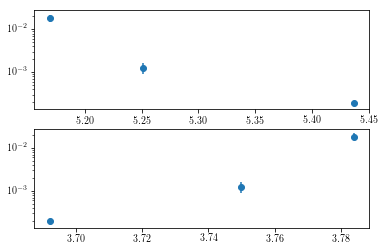

In [17]:
fig, ax = plt.subplots(2)
ax[0].errorbar(logLs,alpha_0s,yerr=e_alpha_0s,fmt='o')
ax[0].set_yscale('log')
ax[1].errorbar(logTs,alpha_0s,yerr=e_alpha_0s,fmt='o')
ax[1].set_yscale('log')

<ErrorbarContainer object of 3 artists>

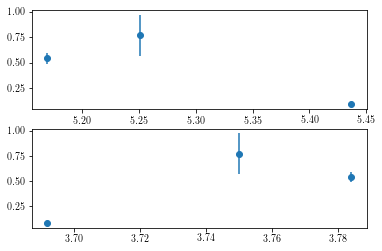

In [18]:
fig, ax = plt.subplots(2)
ax[0].errorbar(logLs,taus,yerr=e_taus,fmt='o')
#ax[0].set_yscale('log')
ax[1].errorbar(logTs,taus,yerr=e_taus,fmt='o')
#ax[1].set_yscale('log')

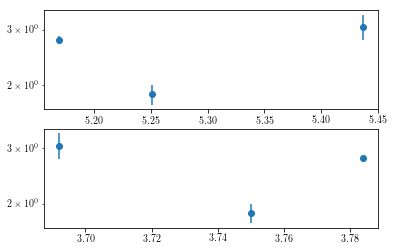

In [19]:
fig, ax = plt.subplots(2)
ax[0].errorbar(logLs,gammas,yerr=e_gammas,fmt='o')
ax[0].set_yscale('log')
ax[1].errorbar(logTs,gammas,yerr=e_gammas,fmt='o')
ax[1].set_yscale('log')

In [8]:
def prewhiten(time, flux, error, frac_rms = 0.1):
    """Pre whitens lightcurve by fitting with sins and subtracting iteratively until the 
    amplitude is less than the rms scatter
    
    Parameters
    ----------
    time
    
    flux
    
    error
    
    frac_rms : float
        Continue subtracting sins until the amplitudes are beloc frac_rms of the rms
    
    Returns
    -------
    f, p : frequency and power of the whitened lomb-scargle periodogram
    
    wflu : the whitened flux array to check on
    """
    
    rms = np.sqrt(np.mean(np.power(flux-np.mean(flux),2.0)))
    amp = 2.0*rms
    wflux = flux.copy()
    rnd = 1
    
    while amp >= frac_rms*rms:
        
        print(rnd)
        
        ls = LombScargle(time, wflux)
        f, p = ls.autopower(minimum_frequency=1.0/30.0,
                            maximum_frequency=1.0/0.1)
        fs, ps = peak_finder(f, p, 1, width=10)
        
        dom = fs[0]
        
        tfit = np.linspace(np.min(time),np.max(time),1000)
        mod = ls.model(tfit, dom)
        amp = 0.5*(np.max(mod)-np.min(mod))
        
        modsub = ls.model(time, dom)
        
        wflux -= modsub
        
        rnd += 1
        
    ls = LombScargle(time, wflux)
    f, p = ls.autopower(minimum_frequency=1.0/30.0,
                        maximum_frequency=1.0/0.1)
    
    return f, p, wflux

HD 269953
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
HD 270046
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66

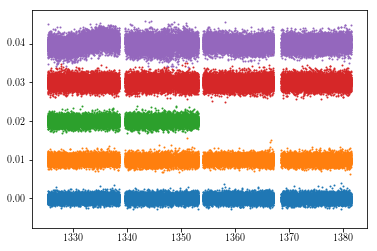

In [9]:
for i,tid in enumerate(ysg_tics):
    fname = np.unique(massive['CommonName'][massive['ticid']==tid])[0].replace('*','').replace('V','')
    print(fname)
    lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
    
    time, flux, err = lc['Time'], lc['Flux'], lc['Err']
    
    f, p, wflux = prewhiten(time, flux, err, frac_rms=0.01)

    plt.scatter(time, wflux + 0.01*i, s=1, label=fname)